In this section, given a trained deep model from the previous section, we run it on pair of stereo images and obtain the disparity map between them. The basic idea is to pass the pair of images through the network optimised for disparity estimation. The disparity is obtained by computing the similarities betwen the images in deep feature space.

In [15]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
from os.path import join
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
root  = 'data'

Using cuda device


In [3]:
# trained model file (from previous section)
model_fn = join(root, 'model.t7')

# running mean and variances of batch norm layers
bn_running_mean_fn = join(root, 'bn_mean.pkl')
bn_running_var_fn = join(root, 'bn_var.pkl')

# colour images
nChannel = 3     

# search range
disp_range = 128

# fixed seed for random variable generation.
# so that we get the same result when we run
# multiple times
torch.manual_seed(123)

In [4]:
class Net(nn.Module):    
    def __init__(self, nChannel):
        super(Net, self).__init__()                
        self.pad = nn.ReflectionPad2d(18)          #perform 18 pixel padding on the image on all sides.
        
        self.conv1 = nn.Conv2d(nChannel, 32, 5)    # first conv layer: 32 filters of size 5x5
        self.batchnorm1 = nn.BatchNorm2d(32, 1e-3) # first batch normalization layer
        
        self.conv2 = nn.Conv2d(32, 32, 5)          # second conv layer: 32 filters of size 5x5
        self.batchnorm2 = nn.BatchNorm2d(32, 1e-3) # second normalization layer
        
        self.conv3 = nn.Conv2d(32, 64, 5)          # third conv layer: 64 filters of size 5x5
        self.batchnorm3 = nn.BatchNorm2d(64, 1e-3) # third batch normalization layer
        
        self.conv4 = nn.Conv2d(64, 64, 5)          # fourth conv layer: 64 filters of size 5x5
        self.batchnorm4 = nn.BatchNorm2d(64, 1e-3) # fourth batch normalization layer
        
        self.conv5 = nn.Conv2d(64, 64, 5)          # fifth conv layer: 64 filters of size 5x5
        self.batchnorm5 = nn.BatchNorm2d(64, 1e-3) # fifth batch normalization layer
        
        self.conv6 = nn.Conv2d(64, 64, 5)          # sixth conv layer: 64 filters of size 5x5
        self.batchnorm6 = nn.BatchNorm2d(64, 1e-3) # sixth batch normalization layer
        
        self.conv7 = nn.Conv2d(64, 64, 5)          # seventh conv layer: 64 filters of size 5x5
        self.batchnorm7 = nn.BatchNorm2d(64, 1e-3) # seventh batch normalization layer
        
        self.conv8 = nn.Conv2d(64, 64, 5)          # eighth conv layer: 64 filters of size 5x5
        self.batchnorm8 = nn.BatchNorm2d(64, 1e-3) # eigth batch normalization layer        
            
        self.conv9 = nn.Conv2d(64, 64, 5)          # ninth conv layer: 64 filters of size 5x5
        self.batchnorm9 = nn.BatchNorm2d(64, 1e-3) # ninth batch normalization layer                                
        
        
    def forward(self, x):
        
        x = self.pad(x)                
        x = self.conv1(x)                
        x = F.relu(self.batchnorm1(x))
        
        x = self.conv2(x)
        x = F.relu(self.batchnorm2(x))
        
        x = self.conv3(x)
        x = F.relu(self.batchnorm3(x))
        
        x = self.conv4(x)
        x = F.relu(self.batchnorm4(x))
        
        x = self.conv5(x)
        x = F.relu(self.batchnorm5(x))
        
        x = self.conv6(x)
        x = F.relu(self.batchnorm6(x))
        
        x = self.conv7(x)
        x = F.relu(self.batchnorm7(x))
        
        x = self.conv8(x)
        x = F.relu(self.batchnorm8(x))
        
        x = self.conv9(x)
        x = self.batchnorm9(x)
                
        return x       
        

In [5]:
#loading the trained model
net = Net(nChannel)
net.load_state_dict(torch.load(model_fn))
net.eval()
print(net)

Net(
  (pad): ReflectionPad2d((18, 18, 18, 18))
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm4): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm5): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm6): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): 

In [6]:
net = net.to(device)

In [7]:
# set batch norm running mean and variance parameters.. this is important when using batch normalization layer
bn_mean, bn_var = torch.load(bn_running_mean_fn), torch.load(bn_running_var_fn)

for i in range(9):
	bn_mean[i], bn_var[i] = bn_mean[i].to(device), bn_var[i].to(device)

net.batchnorm1.running_mean, net.batchnorm1.running_var = bn_mean[0], bn_var[0]
net.batchnorm2.running_mean, net.batchnorm2.running_var = bn_mean[1], bn_var[1]
net.batchnorm3.running_mean, net.batchnorm3.running_var = bn_mean[2], bn_var[2]
net.batchnorm4.running_mean, net.batchnorm4.running_var = bn_mean[3], bn_var[3]
net.batchnorm5.running_mean, net.batchnorm5.running_var = bn_mean[4], bn_var[4]
net.batchnorm6.running_mean, net.batchnorm6.running_var = bn_mean[5], bn_var[5]
net.batchnorm7.running_mean, net.batchnorm7.running_var = bn_mean[6], bn_var[6]
net.batchnorm8.running_mean, net.batchnorm8.running_var = bn_mean[7], bn_var[7]
net.batchnorm9.running_mean, net.batchnorm9.running_var = bn_mean[8], bn_var[8]

In [8]:
# some functions to dispay images and disparity maps in ipython notebook
    
#convert disparity to colour image
def disparity_to_color(I):
    
    _map = np.array([[0,0, 0, 114], [0, 0, 1, 185], [1, 0, 0, 114], [1, 0, 1, 174], 
                    [0, 1, 0, 114], [0, 1, 1, 185], [1, 1, 0, 114], [1, 1, 1, 0]]
                   )      
    max_disp = 1.0*I.max()
    I = np.minimum(I/max_disp, np.ones_like(I))
    
    A = I.transpose()
    num_A = A.shape[0]*A.shape[1]
    
    bins = _map[0:_map.shape[0]-1,3]    
    cbins = np.cumsum(bins)    
    cbins_end = cbins[-1]
    bins = bins/(1.0*cbins_end)
    cbins = cbins[0:len(cbins)-1]/(1.0*cbins_end)
    
    A = A.reshape(1,num_A)            
    B = np.tile(A,(6,1))        
    C = np.tile(np.array(cbins).reshape(-1,1),(1,num_A))
       
    ind = np.minimum(sum(B > C),6)
    bins = 1/bins
    cbins = np.insert(cbins, 0,0)
    
    A = np.multiply(A-cbins[ind], bins[ind])   
    K1 = np.multiply(_map[ind,0:3], np.tile(1-A, (3,1)).T)
    K2 = np.multiply(_map[ind+1,0:3], np.tile(A, (3,1)).T)
    K3 = np.minimum(np.maximum(K1+K2,0),1)
    
    return np.reshape(K3, (I.shape[1],I.shape[0],3)).T

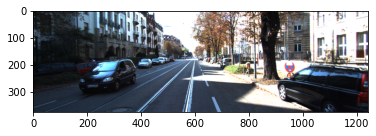

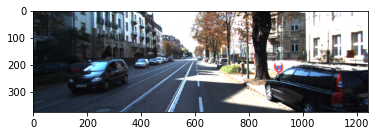

Image size: 375 1242


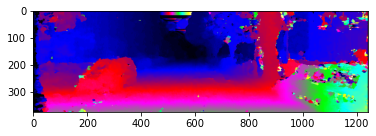

In [18]:
# testing

# left image
left_image_fn = join(root, 'kitti2015_000000_10_L.png')
#left_image_fn = '../../data/lab6/imgL.png'

# right image
right_image_fn =  join(root, 'kitti2015_000000_10_R.png')
#right_image_fn = '../../data/lab6/imgR.png'

# display left and right images
plt.imshow(Image.open(left_image_fn))
plt.show()
plt.imshow(Image.open(right_image_fn))
plt.show()



# read images into tensor
l_img = 255*transforms.ToTensor()(Image.open(left_image_fn))
r_img = 255*transforms.ToTensor()(Image.open(right_image_fn))

# normalize images. All the patches used for training were normalized.
l_img = (l_img -l_img.mean())/(l_img.std())
r_img = (r_img -r_img.mean())/(r_img.std())

img_h = l_img.size(1)
img_w = l_img.size(2)
print('Image size:', img_h, img_w)

# convert to batch x channel x height x width format
l_img = l_img.view(1, l_img.size(0), l_img.size(1), l_img.size(2))
r_img = r_img.view(1, r_img.size(0), r_img.size(1), r_img.size(2))

l_img = l_img.to(device)
r_img = r_img.to(device)

# forward pass. extract deep features
# forward pass left image
with torch.no_grad():
	left_feat = net(l_img)
# forward pass right image
	right_feat = net(r_img)

# output tensor
output = torch.Tensor(img_h, img_w, disp_range).zero_() 
output = output.to(device)

# correlation in deep feature space
# we slide the left image over right image for "disp_range" locations
# in x-direction and then correlate the features in the overlapping window
end_id = img_w-1
for loc_idx in range(disp_range):   
	# 1 x 64 x height x (overlap in x-direction after sliding by loc_idx)      
	# overlapping region loc_idx:img_w-1
	l = left_feat[:,:,:,loc_idx:end_id]        
	# 1 x 64 x height x (overlap in x-direction after sliding by loc_idx)
	# overlap region 0:end_id-loc_idx
	r = right_feat[:,:,:,0:end_id-loc_idx]         
	p = torch.mul(l,r)         # elementwise multiply 64 dimensional feature   
	x = torch.sum(p, 1)        # and add                 
	output[:, loc_idx:end_id, loc_idx] = x.squeeze()

# find the location with maximum score at each pixel in the 3D output (height x width x 64)
max_disp, pred = torch.max(output,2)

# disparity map (height x width)
pred = pred.view(output.size(0),output.size(1))

# convert to colour
color_map = disparity_to_color(pred.float().cpu().numpy())
# showarray(255*np.transpose(color_map, axes=[1,2,0]))
plt.imshow(np.transpose(color_map, axes=[1,2,0]))

Final note: Its a common practice to apply post-processing to smooth the images. We are not considering the output smoothing in this tutorial. Interested readers can refer to "Wenjie Luo et al. Efficient Deep Learning for Stereo Matching"